We can define the LP as follows. $n$ is the length of the grid, and $s$ is the length of a sub-square within the grid. For instance, if $n = 9$, $s = 3$.

\begin{alignat*}{3}
\sum_{i, j}^{n} x_{ijv} = 1 \\
\sum_{i, v}^{n} x_{ijv} = 1 \\
\sum_{j, v}^{n} x_{ijv} = 1 \\
\sum_{i=si'}^{s(i'+1)} \sum_{j=sj'}^{s(j'+1)} x_{ijv} = 1 \\
i, j, v \in [1, n] \\
i', j' \in [1, s]
\end{alignat*}

In [1]:
import random
import copy
import time
import os
import gurobipy as gp
from gurobipy import GRB, quicksum, max_, abs_
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def load_test(size):
    if size == 9:
        grid = np.zeros((9,9))
        grid[0][1]=2
        grid[0][4]=3
        grid[0][7]=4
        grid[1][0]=6
        grid[1][8]=3
        grid[2][2]=4
        grid[2][6]=5
        grid[3][3]=8
        grid[3][5]=6
        grid[4][0]=8
        grid[4][4]=1
        grid[4][8]=6
        grid[5][3]=7
        grid[5][5]=5
        grid[6][2]=7
        grid[6][6]=6
        grid[7][0]=4
        grid[7][8]=8
        grid[8][1]=3
        grid[8][4]=4
        grid[8][7]=2
        return grid
    else:
        grid = np.zeros((12,12))
        grid[1][0] = 2
        grid[1][1] = 12
        grid[1][10] = 7
        grid[2][1] = 3
        grid[3][1] = 5
        grid[4][2] = 4
        grid[5][2] = 9
        grid[7][0] = 6
        grid[8][1] = 8
        grid[8][2] = 2
        grid[8][3] = 5
        grid[9][0] = 12
        grid[9][1] = 4
        grid[9][2] = 7
        grid[10][1] = 10
        grid[11][0] = 1
        grid[11][2] = 5

        grid[1][5] = 4
        grid[1][7] = 9
        grid[2][4] = 1
        grid[2][5] = 7
        grid[2][6] = 6
        grid[3][7] = 11
        grid[4][4] = 6
        grid[4][7] = 5
        grid[5][5] = 2
        grid[5][6] = 8
        grid[6][5] = 10
        grid[6][6] = 7
        grid[7][4] = 8
        grid[7][7] = 12
        grid[8][4] = 3
        grid[9][5] = 3
        grid[9][6] = 9
        grid[9][7] = 1
        grid[10][4] = 12
        grid[10][6] = 2

        grid[0][9] = 1
        grid[0][11] = 9
        grid[1][10] = 7
        grid[2][9] = 12
        grid[2][10] = 10
        grid[2][11] = 11
        grid[3][8] = 8
        grid[3][9] = 6
        grid[3][10] = 2
        grid[4][11] = 1
        grid[6][9] = 8
        grid[7][9] = 3
        grid[8][10] = 12
        grid[9][10] = 5
        grid[10][10] = 1
        grid[10][11] = 3

        return grid

In [4]:
def print_solution(grid, model, variables, si, sj):
    print('')
    print('Solution:')
    print('')
    n = len(grid[0])

    # Retrieve optimization result

    solution = model.getAttr('X', variables)

    for i in range(n):
        sol = ''
        if i != 0 and i % sj == 0:
            sol += '\n'
        for j in range(n):
            if j != 0 and j % si == 0:
                sol += '  '
            for v in range(n):
                if solution[i, j, v] > 0.5:
                    sol += str(v+1).rjust(n//10 + 2)
        print(sol)

In [5]:
# def gurobi_solution(grid):
# # In the MIP formulation, binary variables x[i,j,v] indicate whether
# # cell <i,j> takes value 'v'.  The constraints are as follows:
# #   1. Each cell must take exactly one value (sum_v x[i,j,v] = 1)
# #   2. Each value is used exactly once per row (sum_i x[i,j,v] = 1)
# #   3. Each value is used exactly once per column (sum_j x[i,j,v] = 1)
# #   4. Each value is used exactly once per 3x3 subgrid (sum_grid x[i,j,v] = 1)

#     n = len(grid[0])
#     s = int(n**0.5)
#     model = gp.Model('gurobi')
# #     model.Params.LogToConsole = 0
#     var = model.addVars(n, n, n, vtype=GRB.BINARY, name='G')


#     # Fix variables associated with cells whose values are pre-specified
#     for i in range(n):
#         for j in range(n):
#             if grid[i][j] > 0:
#                 v = int(grid[i][j]) - 1
#                 var[i, j, v].LB = 1


#     # Each cell must take one value
#     model.addConstrs((var.sum(r, c, '*') == 1
#                      for r in range(n)
#                      for c in range(n)), name='V')


#     # Each value appears once per row
#     model.addConstrs((var.sum(r, '*', v) == 1
#                      for r in range(n)
#                      for v in range(n)), name='R')


#     # Each value appears once per column
#     model.addConstrs((var.sum('*', c, v) == 1
#                      for c in range(n)
#                      for v in range(n)), name='C')


#     # Each value appears once per subgrid
#     model.addConstrs((
#         gp.quicksum(var[i, j, v] for i in range(i0*s, (i0+1)*s)
#                     for j in range(j0*s, (j0+1)*s)) == 1
#         for v in range(n)
#         for i0 in range(s)
#         for j0 in range(s)), name='Sub')

#     model.optimize()

#     return model, var

In [6]:
def gurobi_solution(grid, si, sj, sols=1):
# In the MIP formulation, binary variables x[i,j,v] indicate whether
# cell <i,j> takes value 'v'.  The constraints are as follows:
#   1. Each cell must take exactly one value (sum_v x[i,j,v] = 1)
#   2. Each value is used exactly once per row (sum_i x[i,j,v] = 1)
#   3. Each value is used exactly once per column (sum_j x[i,j,v] = 1)
#   4. Each value is used exactly once per si x sj subgrid (sum_grid x[i,j,v] = 1)

    n = len(grid[0])
    model = gp.Model('gurobi')
    if sols > 1:
        model.Params.LogToConsole = 0
        model.params.OutputFlag = 0
        model.Params.PoolSolutions = sols
        model.Params.PoolSearchMode = 2
    var = model.addVars(n, n, n, vtype=GRB.BINARY, name='G')


    # Fix variables associated with cells whose values are pre-specified
    for i in range(n):
        for j in range(n):
            if grid[i][j] > 0:
                v = int(grid[i][j]) - 1
                var[i, j, v].LB = 1


    # Each cell must take one value
    model.addConstrs((var.sum(r, c, '*') == 1
                     for r in range(n)
                     for c in range(n)), name='V')


    # Each value appears once per row
    model.addConstrs((var.sum(r, '*', v) == 1
                     for r in range(n)
                     for v in range(n)), name='R')


    # Each value appears once per column
    model.addConstrs((var.sum('*', c, v) == 1
                     for c in range(n)
                     for v in range(n)), name='C')


    # Each value appears once per subgrid
    model.addConstrs((
        gp.quicksum(var[i, j, v] for i in range(i0*sj, (i0+1)*sj)
                    for j in range(j0*si, (j0+1)*si)) == 1
        for v in range(n)
        for i0 in range(si)
        for j0 in range(sj)), name='Sub')

    model.optimize()
    
    solution = np.zeros((n,n))
    sol = model.getAttr('X', var)
    for i in range(n):
        for j in range(n):
            for v in range(n):
                if sol[i, j, v] > 0.5:
                    solution[i][j] = v + 1

    return model, var, solution, model.SolCount

In [7]:
# grid = load_test(9)
# mdl, var = gurobi_solution(grid)
# print_solution(grid, mdl, var)

# grid = load_test(12)
# mdl, var, solution, cnt = gurobi_solution2(grid, 4, 3)
# print_solution2(grid, mdl, var, 4, 3)

In [8]:
# def is_used(grid, row, col, num):
#     if in_row(grid, row, num):
#         return True
#     elif in_col(grid, col, num):
#         return True
#     elif in_mini(grid, row, col, num):
#         return True
#     return False
    

# def in_row(grid, row, num):
#     return num in grid[row]


# def in_col(grid, col, num):
#     size = len(grid[0])
#     col_list = [grid[r][col] for r in range(size)]
#     return num in col_list


# def get_mini_list(grid, row, col):
#     size = len(grid[0])
#     root = int(size**0.5)
#     mini_row = root*(row // root)
#     mini_row2 = mini_row + root
#     mini_col = root*(col // root)
#     mini_col2 = mini_col + root
#     mini_list = [grid[r][c] for r in range(mini_row, mini_row2) for c in range(mini_col, mini_col2)]
#     return mini_list


# def in_mini(grid, row, col, num):
#     return num in get_mini_list(grid, row, col)


# def has_zeroes(grid):
#     size = len(grid[0])
#     for row in range(size):
#         if 0 in grid[row]:
#             return True
#     return False

# def count_occurances(grid, num=0):
#     return sum(cell == num for row in grid for cell in row)

In [9]:
# def generate_grid(size=9):
#     if(size**0.5 != int(size**0.5)):
#         raise ValueError("Size must be a perfect square")
#     grid = create_empty_grid(size)
#     fill_grid(grid)
#     return grid


# def fill_grid(grid, solve=False):
#     global solver_counter
#     size = len(grid[0])
#     squared = size**2
#     numbers = [temp+1 for temp in range(size)]
#     for i in range(0, squared):
#         row = i // size
#         col = i % size
#         if grid[row][col] != 0:
#             continue
#         if not solve:
#             random.shuffle(numbers)
#         for num in numbers:
#             if not is_used(grid, row, col, num):
#                 grid[row][col] = num
#                 if not has_zeroes(grid):
#                     solver_counter += 1
#                     if solve:
#                         break
#                     return True
#                 elif fill_grid(grid, solve):
#                     return True
#         break
#     grid[row][col] = 0


In [10]:
# def sparsify(grid, attempts=5):
#     # larger number of attempts = the more sparse it gets
#     # Warning this could go for awhile!
#     global solver_counter
#     size = len(grid[0])
#     original = copy.deepcopy(grid)
#     while attempts > 0:
#         row = random.randint(0, size-1)
#         col = random.randint(0, size-1)
#         while grid[row][col] == 0:
#             row = random.randint(0, size-1)
#             col = random.randint(0, size-1)
        
#         backup = grid[row][col]
#         grid[row][col] = 0
#         test_grid = copy.deepcopy(grid)

#         solver_counter = 0
#         fill_grid(test_grid, True)

#         if solver_counter != 1:
#             grid[row][col] = backup
#             attempts -= 1
#             print("DECREMENTING ATTEMPTS {} - solver_counter={}".format(attempts, solver_counter))
#     return original, grid


# def sparsify_no_check(grid, num_clues=None):
#     size = len(grid[0])
#     clues = num_clues or (size**2 // 4) # just a good speculation
#     # 9x9 min = 17     (size**2 // 4 == 20)
#     # 16x16 min ?= 51  (size**2 // 4 == 64)
#     # 25x25 min ?= 151 (size**2 // 4 == 156)
#     original = copy.deepcopy(grid)
#     remaining = size**2
#     while remaining > clues:
#         row = random.randint(0, size-1)
#         col = random.randint(0, size-1)
#         while grid[row][col] == 0:
#             row = random.randint(0, size-1)
#             col = random.randint(0, size-1)
#         grid[row][col] = 0
#         remaining -= 1
#     return original, grid

In [11]:
def is_used(grid, si, sj, row, col, num):
    if in_row(grid, row, num):
        return True
    elif in_col(grid, col, num):
        return True
    elif in_mini(grid, si, sj, row, col, num):
        return True
    return False
    

def in_row(grid, row, num):
    return num in grid[row]


def in_col(grid, col, num):
    size = len(grid[0])
    col_list = [grid[r][col] for r in range(size)]
    return num in col_list


def in_mini(grid, si, sj, row, col, num):
    return num in get_mini_list(grid, si, sj, row, col)


def get_mini_list(grid, si, sj, row, col):
    size = len(grid[0])
    root = int(size**0.5)
    mini_row = sj*(row // sj)
    mini_row2 = mini_row + sj
    mini_col = si*(col // si)
    mini_col2 = mini_col + si
    mini_list = [grid[r][c] for r in range(mini_row, mini_row2) for c in range(mini_col, mini_col2)]
    return mini_list


def has_zeroes(grid):
    size = len(grid[0])
    for row in range(size):
        if 0 in grid[row]:
            return True
    return False


def count_occurances(grid, num=0):
    return sum(cell == num for row in grid for cell in row)

In [12]:
global solver_counter
solver_counter = 0

def generate_grid(size=9, si=None, sj=None):
    if(si is None and sj is None):
        if(size**0.5 != int(size**0.5)):
            raise ValueError("Size must be a perfect square, or smaller subgrid dimensions need to be provided")
        si = int(size**0.5)
        sj = int(size**0.5)
    grid = np.zeros((size,size))
    fill_grid(grid, si, sj)
    return grid


def fill_grid(grid, si, sj, solve=False):
    global solver_counter
    size = len(grid[0])
    squared = size**2
    numbers = [temp+1 for temp in range(size)]
    for i in range(0, squared):
        row = i // size
        col = i % size
        if grid[row][col] != 0:
            continue
        if not solve:
            random.shuffle(numbers)
        for num in numbers:
            if not is_used(grid, si, sj, row, col, num):
                grid[row][col] = num
                if not has_zeroes(grid):
                    solver_counter += 1
                    if solve:
                        break
                    return True
                elif fill_grid(grid, si, sj, solve):
                    return True
        break
    grid[row][col] = 0

In [13]:
def sparsify(g, si, sj, num_clues=0, validate=True):
    original = copy.deepcopy(g)
    grid = copy.deepcopy(g)
    n = len(grid[0])
    remaining = n**2
    clues = num_clues or (n**2 // 4) # just a good speculation
    max_iter = int(n**2.5)
    # 9x9 min = 17     (size**2 // 4 == 20)
    # 12x12 min = 30   (size**2 // 4 == 36)
    # 16x16 min ?= 51  (size**2 // 4 == 64)
    # 25x25 min ?= 151 (size**2 // 4 == 156)
    row = random.randint(1, n) - 1
    col = random.randint(1, n) - 1
    iteration = -1
    stats = []
    while remaining > clues and iteration < max_iter:
        iteration += 1
        x = 0
        while not x:
            row = random.randint(1, n) - 1
            col = random.randint(1, n) - 1
            x = grid[row][col]
        orig_val = grid[row][col]
        grid[row][col] = 0
        remaining -= 1
        if validate:
            m, v, sol, cnt = gurobi_solution(grid, si, sj, sols=2)
            print(f"iter {str(iteration).rjust(4)}/{max_iter}  grid[{str(row).rjust(2)}][{str(col).rjust(2)}] = {orig_val}  sol_cnt = {cnt}  rem = {remaining}  soltime = {m.Runtime}")
            stats.append({
                "clues": clues,
                "max_iter": max_iter,
                "iter": iteration,
                "remaining": remaining,
                "row": row,
                "col": col,
                "orig_val": orig_val,
                "sol_cnt": cnt,
                "runtime": m.Runtime
            })
            if cnt != 1: # 0 = not solvable, 2 = too many
                grid[row][col] = orig_val
                remaining += 1
    return original, grid, stats

In [14]:
test = np.zeros((8,8))
fill_grid(test, 4, 2)
o, g, stats = sparsify(test, 4, 2)

Using license file C:\Users\marka\gurobi.lic
Academic license - for non-commercial use only
iter    0/181  grid[ 3][ 5] = 4.0  sol_cnt = 1  rem = 63  soltime = 0.018003463745117188
iter    1/181  grid[ 4][ 4] = 1.0  sol_cnt = 1  rem = 62  soltime = 0.0020008087158203125
iter    2/181  grid[ 6][ 3] = 5.0  sol_cnt = 1  rem = 61  soltime = 0.00099945068359375
iter    3/181  grid[ 7][ 0] = 8.0  sol_cnt = 1  rem = 60  soltime = 0.0020008087158203125
iter    4/181  grid[ 2][ 3] = 4.0  sol_cnt = 1  rem = 59  soltime = 0.0010013580322265625
iter    5/181  grid[ 6][ 7] = 1.0  sol_cnt = 1  rem = 58  soltime = 0.0020313262939453125
iter    6/181  grid[ 5][ 1] = 7.0  sol_cnt = 1  rem = 57  soltime = 0.0019989013671875
iter    7/181  grid[ 0][ 1] = 4.0  sol_cnt = 1  rem = 56  soltime = 0.0010089874267578125
iter    8/181  grid[ 7][ 6] = 2.0  sol_cnt = 1  rem = 55  soltime = 0.0020008087158203125
iter    9/181  grid[ 0][ 7] = 3.0  sol_cnt = 1  rem = 54  soltime = 0.002002716064453125
iter   10/181  

iter   95/181  grid[ 5][ 0] = 1.0  sol_cnt = 2  rem = 21  soltime = 0.008998870849609375
iter   96/181  grid[ 6][ 2] = 7.0  sol_cnt = 2  rem = 21  soltime = 0.013002395629882812
iter   97/181  grid[ 0][ 5] = 6.0  sol_cnt = 1  rem = 21  soltime = 0.0030002593994140625
iter   98/181  grid[ 3][ 2] = 6.0  sol_cnt = 2  rem = 20  soltime = 0.007997512817382812
iter   99/181  grid[ 1][ 0] = 6.0  sol_cnt = 2  rem = 20  soltime = 0.008001327514648438
iter  100/181  grid[ 5][ 5] = 2.0  sol_cnt = 2  rem = 20  soltime = 0.0070171356201171875
iter  101/181  grid[ 6][ 1] = 2.0  sol_cnt = 2  rem = 20  soltime = 0.0069980621337890625
iter  102/181  grid[ 3][ 3] = 3.0  sol_cnt = 2  rem = 20  soltime = 0.008996963500976562
iter  103/181  grid[ 1][ 4] = 5.0  sol_cnt = 2  rem = 20  soltime = 0.008001327514648438
iter  104/181  grid[ 4][ 3] = 2.0  sol_cnt = 2  rem = 20  soltime = 0.0049991607666015625
iter  105/181  grid[ 3][ 4] = 7.0  sol_cnt = 2  rem = 20  soltime = 0.006999969482421875
iter  106/181  gr

In [15]:
o

array([[5., 4., 2., 1., 8., 6., 7., 3.],
       [6., 8., 3., 7., 5., 1., 4., 2.],
       [7., 1., 8., 4., 2., 3., 6., 5.],
       [2., 5., 6., 3., 7., 4., 1., 8.],
       [3., 6., 5., 2., 1., 7., 8., 4.],
       [1., 7., 4., 8., 3., 2., 5., 6.],
       [4., 2., 7., 5., 6., 8., 3., 1.],
       [8., 3., 1., 6., 4., 5., 2., 7.]])

In [16]:
g

array([[5., 0., 2., 0., 0., 0., 0., 0.],
       [6., 0., 0., 0., 5., 1., 0., 0.],
       [0., 1., 0., 0., 0., 3., 0., 0.],
       [0., 0., 6., 3., 7., 0., 1., 0.],
       [0., 0., 5., 2., 0., 0., 0., 0.],
       [1., 0., 0., 8., 0., 2., 5., 0.],
       [4., 2., 7., 0., 6., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [17]:
tests = [
    {
        "size":8,
        "si":4,
        "sj":2,
        "clues":0
    },
    {
        "size":9,
        "si":3,
        "sj":3,
        "clues":0
    },
    {
        "size":10,
        "si":5,
        "sj":2,
        "clues":0
    },
    {
        "size":12,
        "si":4,
        "sj":3,
        "clues":0
    },
    {
        "size":12,
        "si":6,
        "sj":2,
        "clues":0
    },
    {
        "size":16,
        "si":4,
        "sj":4,
        "clues":0
    },
    {
        "size":16,
        "si":8,
        "sj":2,
        "clues":0
    },
    {
        "size":20,
        "si":5,
        "sj":4,
        "clues":0
    },
    {
        "size":20,
        "si":10,
        "sj":2,
        "clues":0
    },
    {
        "size":24,
        "si":6,
        "sj":4,
        "clues":0
    },
    {
        "size":24,
        "si":8,
        "sj":3,
        "clues":0
    },
    {
        "size":24,
        "si":12,
        "sj":2,
        "clues":0
    },
    {
        "size":25,
        "si":5,
        "sj":5,
        "clues":0
    },
    {
        "size":24,
        "si":8,
        "sj":3,
        "clues":0
    },
    {
        "size":24,
        "si":12,
        "sj":2,
        "clues":0
    },
    {
        "size":25,
        "si":5,
        "sj":5,
        "clues":0
    }
]

In [18]:
def run_tests(size, si, sj, clues, iterations=10):
    results = []
    clue_goal = clues or (size**2 // 4) # same formula as sparsify3()
    overall_start = time.time()
    for i in range(iterations):
        print("\n\n\n------------  TEST {}/{}   SIZE={} ({}x{})   CLUE GOAL={}  ------------".format(
                i+1, iterations, size, si, sj, clue_goal))
        itestgrid = np.zeros((size, size))
        filling_start = time.time()
        fill_grid(itestgrid, si, sj)
        filling = time.time() - filling_start
        sparsing_start = time.time()
        o, g, stat = sparsify(itestgrid, si, sj, clues)
        sparsing = time.time() - sparsing_start
        results.append({
            'grid': o,
            'sparsed': g,
            'stats': stat,
            'clue_goal': clue_goal,
            'clue_count': size**2 - count_occurances(g, 0),
            'timings_filling': filling,
            'timings_sparsing': sparsing,
            'timings_overall': time.time() - overall_start
        })
    overall_time = time.time() - overall_start
    print("\n\nDONE ({})\n\n".format(overall_time))    
    return results, overall_time

In [19]:
# test_iterations = 10

# for idx, test in enumerate(tests):
#     t = copy.deepcopy(test)
#     results, overall_time = run_tests(**t, iterations=test_iterations)
#     t['results'] = results
#     t['overall_time'] = overall_time
#     t2 = np.array(t)
#     np.save("test_{}_{}x{}_{}_of_{}.npy".format(t['size'], t['si'], t['sj'], idx, len(tests)), t2)

In [20]:
def sparsify_test(filled_grid, si, sj, iterations=10):
#     Same grid but sparsifying it multiple times (randomization should give different results)
    size = si * sj
    clue_goal = clues or (size**2 // 4) # same formula as sparsify3()
    results = []
    overall_start = time.time()
    for i in range(iterations):
        print("\n\n\n------------  SPARSE TEST {}/{}   SIZE={} ({}x{})   CLUE GOAL={}  ------------".format(
                i+1, iterations, size, si, sj, clue_goal))
        sparsing_start = time.time()
        o, g, stat = sparsify3(filled_grid, si, sj, clues)
        sparsing = time.time() - sparsing_start
        results.append({
            'grid': o,
            'sparsed': g,
            'stats': stat,
            'clue_goal': clue_goal,
            'clue_count': size**2 - count_occurances(g, 0),
            'timings': {
                'filling': 0.0,
                'sparsing': sparsing,
                'overall': time.time() - overall_start
            }
        })
    overall_time = time.time() - overall_start
    print("\n\nDONE ({})\n\n".format(overall_time))    
    return results, overall_time

In [21]:
def load(specific_filename="all_runs.npy"): # None for all .npy files
    data = {}
    for filename in os.listdir('.'):
        if not filename.endswith('.npy'):
            continue
        if specific_filename is not None and specific_filename != filename:
            continue
        raw_data = np.load(filename, allow_pickle=True).item()
        if specific_filename == "all_runs.npy":
            return raw_data
        if 'results' in raw_data and 'timings' in raw_data['results'][0]:
            for iteration, results in enumerate(raw_data['results']):
                raw_data['results'][iteration]['timings_filling'] = results['timings']['filling']
                raw_data['results'][iteration]['timings_sparsing'] = results['timings']['sparsing']
                raw_data['results'][iteration]['timings_overall'] = results['timings']['overall']
                del raw_data['results'][iteration]['timings']
        keyname = "{}_{}x{}".format(raw_data['size'], raw_data['si'], raw_data['sj'])
        data[keyname] = raw_data
    return data

In [22]:
data = load()

In [23]:
# np.save('all_runs.npy', data)

In [24]:
all_tests_stats = []
for gsize in data.keys():
    for testnum, result in enumerate(data[gsize]['results']):
        for statnum, stat in enumerate(result['stats']):
            data[gsize]['results'][testnum]['stats'][statnum]['gsize'] = gsize
            data[gsize]['results'][testnum]['stats'][statnum]['testnum'] = testnum
        all_tests_stats.extend(data[gsize]['results'][testnum]['stats'])
df = pd.DataFrame(all_tests_stats)

# Remove outliers
df = df[(df.gsize != '20_5x4') | (df.testnum != 3)]
df = df[(df.gsize != '20_10x2') | (df.testnum != 1)]

In [25]:
df.describe()

,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,testnum
count,70112.000000,70112.000000,70112.000000,70112.000000,70112.000000,70112.000000,70112.000000,70112.000000,70112.000000,70112.000000
mean,72.008358,1218.953617,609.476809,128.275716,7.786599,7.740515,8.732770,1.844563,0.754752,4.627582
std,28.959864,576.027364,484.384244,67.451475,5.221402,5.234845,5.231162,0.362323,1.153620,2.878346
min,16.000000,181.000000,0.000000,18.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,64.000000,1024.000000,201.000000,91.000000,3.000000,3.000000,4.000000,2.000000,0.015999,2.000000
50%,64.000000,1024.000000,476.000000,130.000000,7.000000,7.000000,8.000000,2.000000,0.134027,5.000000
75%,100.000000,1788.000000,925.000000,172.000000,12.000000,12.000000,13.000000,2.000000,1.210486,7.000000
max,100.000000,1788.000000,1788.000000,399.000000,19.000000,19.000000,20.000000,2.000000,13.126951,9.000000


In [26]:
df.head()

,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
0,16,181,0,63,1,2,1.0,1,0.001999,8_4x2,0
1,16,181,1,62,3,4,5.0,1,0.001005,8_4x2,0
2,16,181,2,61,7,1,3.0,1,0.000999,8_4x2,0
3,16,181,3,60,7,5,5.0,1,0.000999,8_4x2,0
4,16,181,4,59,2,0,5.0,1,0.001001,8_4x2,0


In [33]:
def print_indiv_stats(df, gsize):
    stats = {}
    print("\n\n\n\n")
    print(gsize)
    print("\n\n")
    gframe = df[df.gsize == gsize]
    row_cnt = gframe.count() + 1
    tests = list(set(gframe['testnum'].tolist()))
    
    desc = gframe[['remaining', 'runtime']].describe()
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.6f}'.format)
    display(desc)
    
    print("\n\nslowest runtimes:")
    display(gframe.sort_values(by=['runtime'], ascending=False).head())
    
    print("\n\nfastest runtimes:")
    display(gframe.sort_values(by=['runtime'], ascending=True).head())
    
    numbers = gframe['sol_cnt'].value_counts().tolist()
    percents = gframe['sol_cnt'].value_counts(normalize=True).tolist()
    print("\nCell removal gave 1 unique solution:   {} or {:.2f}%".format(numbers[1], 100*percents[1]))
    print("Cell removal gave 2+ solutions:        {} or {:.2f}%".format(numbers[0], 100*percents[0]))
    
    print("\n\nDistribution of Successfully removed values:")
    display(gframe[gframe.sol_cnt==1]['orig_val'].value_counts(normalize=True))
    
    print("\n\nDistribution of Incorrectly removed values:")
    display(gframe[gframe.sol_cnt==2]['orig_val'].value_counts(normalize=True))
    
    
    stats['max_runtimes'] = gframe.sort_values('runtime', ascending=False).drop_duplicates(['testnum'])['runtime'].tolist()
    stats['remaining'] = gframe.sort_values('remaining', ascending=True).drop_duplicates(['testnum'])['remaining'].tolist()
    return stats

In [28]:
# def overall_stats(df):
#     remaining_count_runtime = df.groupby(['remaining'])['remaining', 'runtime'].agg(
#         {'remaining':'count', 'runtime':'mean'}).rename(
#             columns={'remaining_count':'count', 'runtime':'runtime_mean'})
    

In [29]:
# gframe['sol_cnt'].value_counts(normalize=True)
# remaining_count_runtime = df.groupby(['remaining'])['remaining', 'runtime'].agg({'remaining':'count',
#                                                        'runtime':'mean'}).rename(columns={'remaining':'remaining_count',
#                                                        'runtime':'runtime_mean'})
# # with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
# #     display(remaining_count_runtime)
# remaining_count_runtime.plot()

In [30]:
# df[df.gsize=='16_4x4' & df.sol_cnt==1]['orig_val'].value_counts()

# gframe[['orig_val','sol_cnt']].count_values()
# gframe.iloc[gframe['runtime'].idxmax()]


In [31]:
print_indiv_stats(df, '8_4x2')






8_4x2





,remaining,runtime
count,1820,1820
mean,24.865934,0.005808
std,11.481162,0.003885
min,18.000000,0.000000
25%,19.000000,0.002986
50%,19.000000,0.005003
75%,24.000000,0.008007
max,63.000000,0.038002




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
1162,16,181,70,18,7,3,1.0,2,0.038002,8_4x2,6
1165,16,181,73,18,5,5,3.0,2,0.022001,8_4x2,6
505,16,181,141,19,6,4,5.0,2,0.019003,8_4x2,2
441,16,181,77,19,7,0,7.0,2,0.019001,8_4x2,2
328,16,181,146,18,4,7,8.0,2,0.017984,8_4x2,1




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
564,16,181,18,45,1,2,8.0,1,0.0,8_4x2,3
1094,16,181,2,61,7,6,4.0,1,0.0,8_4x2,6
560,16,181,14,49,5,2,6.0,1,0.0,8_4x2,3
1111,16,181,19,45,3,2,1.0,1,0.0,8_4x2,6
558,16,181,12,51,7,6,7.0,1,0.0,8_4x2,3



Cell removal gave 1 unique solution:   443 or 24.34%
Cell removal gave 2+ solutions:        1377 or 75.66%


Distribution of Successfully removed values:


2.0    0.137698
6.0    0.128668
8.0    0.128668
5.0    0.126411
1.0    0.124153
3.0    0.121896
4.0    0.117381
7.0    0.115124
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


4.0    0.156137
3.0    0.143791
7.0    0.140160
1.0    0.124909
2.0    0.119099
5.0    0.114016
6.0    0.103123
8.0    0.098765
Name: orig_val, dtype: float64






8_4x2





,remaining,runtime
count,1820,1820
mean,24.865934,0.005808
std,11.481162,0.003885
min,18.000000,0.000000
25%,19.000000,0.002986
50%,19.000000,0.005003
75%,24.000000,0.008007
max,63.000000,0.038002




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
1162,16,181,70,18,7,3,1.0,2,0.038002,8_4x2,6
1165,16,181,73,18,5,5,3.0,2,0.022001,8_4x2,6
505,16,181,141,19,6,4,5.0,2,0.019003,8_4x2,2
441,16,181,77,19,7,0,7.0,2,0.019001,8_4x2,2
328,16,181,146,18,4,7,8.0,2,0.017984,8_4x2,1




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
564,16,181,18,45,1,2,8.0,1,0.0,8_4x2,3
1094,16,181,2,61,7,6,4.0,1,0.0,8_4x2,6
560,16,181,14,49,5,2,6.0,1,0.0,8_4x2,3
1111,16,181,19,45,3,2,1.0,1,0.0,8_4x2,6
558,16,181,12,51,7,6,7.0,1,0.0,8_4x2,3



Cell removal gave 1 unique solution:   443 or 24.34%
Cell removal gave 2+ solutions:        1377 or 75.66%


Distribution of Successfully removed values:


2.0    0.137698
6.0    0.128668
8.0    0.128668
5.0    0.126411
1.0    0.124153
3.0    0.121896
4.0    0.117381
7.0    0.115124
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


4.0    0.156137
3.0    0.143791
7.0    0.140160
1.0    0.124909
2.0    0.119099
5.0    0.114016
6.0    0.103123
8.0    0.098765
Name: orig_val, dtype: float64

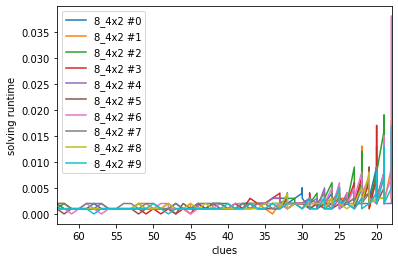

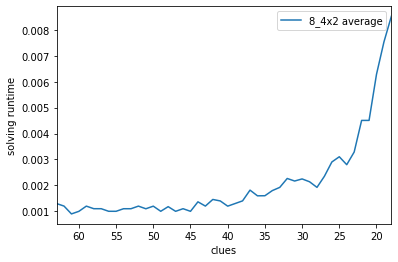






20_10x2





,remaining,runtime
count,16101,16101
mean,189.849947,0.865456
std,43.898083,0.573744
min,170.000000,0.000000
25%,173.000000,0.375132
50%,175.000000,0.936859
75%,179.000000,1.270264
max,399.000000,4.008478




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
56665,100,1788,865,179,19,6,15.0,2,4.008478,20_10x2,0
56634,100,1788,834,180,6,17,3.0,2,3.358250,20_10x2,0
60296,100,1788,918,174,10,10,15.0,1,3.162615,20_10x2,2
60215,100,1788,837,175,12,0,8.0,1,3.078663,20_10x2,2
60266,100,1788,888,174,11,0,14.0,2,3.070919,20_10x2,2




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
64808,100,1788,63,336,18,9,2.0,1,0.0,20_10x2,5
63119,100,1788,163,239,4,11,3.0,1,0.0,20_10x2,4
63120,100,1788,164,238,16,9,1.0,1,0.0,20_10x2,4
63124,100,1788,168,235,4,6,19.0,1,0.0,20_10x2,4
63140,100,1788,184,220,7,11,13.0,1,0.0,20_10x2,4



Cell removal gave 1 unique solution:   2025 or 12.58%
Cell removal gave 2+ solutions:        14076 or 87.42%


Distribution of Successfully removed values:


19.0    0.054321
9.0     0.053333
13.0    0.053333
14.0    0.052840
15.0    0.052346
20.0    0.051358
2.0     0.051358
8.0     0.050370
6.0     0.050370
3.0     0.049877
18.0    0.049383
4.0     0.049383
16.0    0.049383
5.0     0.048889
11.0    0.048395
12.0    0.047901
1.0     0.047901
7.0     0.046914
17.0    0.046420
10.0    0.045926
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


5.0     0.056337
12.0    0.053779
10.0    0.052856
4.0     0.052145
1.0     0.051932
11.0    0.051790
7.0     0.051719
17.0    0.051719
8.0     0.051364
3.0     0.050938
6.0     0.049801
16.0    0.049517
18.0    0.049091
20.0    0.048167
9.0     0.047954
19.0    0.046746
13.0    0.046675
15.0    0.046107
14.0    0.045752
2.0     0.045610
Name: orig_val, dtype: float64

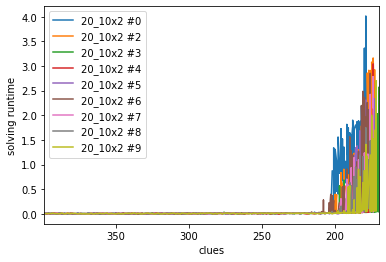

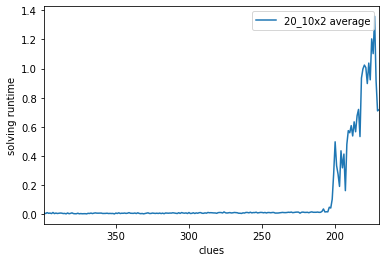






20_5x4





,remaining,runtime
count,16101,16101
mean,176.583194,2.150140
std,48.138510,1.563025
min,154.000000,0.004993
25%,158.000000,1.375084
50%,161.000000,2.013144
75%,163.000000,2.724180
max,399.000000,13.126951




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
40357,100,1788,658,163,3,9,12.0,2,13.126951,20_5x4,1
41260,100,1788,1561,163,3,9,12.0,2,13.123953,20_5x4,1
52127,100,1788,1694,154,9,9,17.0,2,13.056934,20_5x4,7
49751,100,1788,1107,163,19,7,9.0,2,12.943932,20_5x4,6
40236,100,1788,537,163,18,3,2.0,2,12.855913,20_5x4,1




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
37911,100,1788,1,398,4,12,12.0,1,0.004993,20_5x4,0
45096,100,1788,30,369,5,19,16.0,1,0.004997,20_5x4,4
45081,100,1788,15,384,3,0,5.0,1,0.004997,20_5x4,4
37925,100,1788,15,384,4,8,18.0,1,0.004997,20_5x4,0
54011,100,1788,0,399,0,15,19.0,1,0.004999,20_5x4,9



Cell removal gave 1 unique solution:   2156 or 13.39%
Cell removal gave 2+ solutions:        13945 or 86.61%


Distribution of Successfully removed values:


9.0     0.054267
4.0     0.052876
5.0     0.051948
18.0    0.051484
1.0     0.051020
7.0     0.051020
2.0     0.051020
14.0    0.050557
16.0    0.050557
12.0    0.050093
19.0    0.049629
15.0    0.049165
3.0     0.049165
13.0    0.048701
17.0    0.048701
10.0    0.048701
8.0     0.048701
20.0    0.047774
11.0    0.047310
6.0     0.047310
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


11.0    0.056149
8.0     0.054141
3.0     0.054070
20.0    0.052635
6.0     0.052277
7.0     0.051560
19.0    0.050699
12.0    0.050556
1.0     0.050556
2.0     0.049839
15.0    0.049767
10.0    0.049480
17.0    0.048978
16.0    0.048620
14.0    0.047544
18.0    0.047544
5.0     0.047472
13.0    0.047401
4.0     0.045393
9.0     0.045321
Name: orig_val, dtype: float64

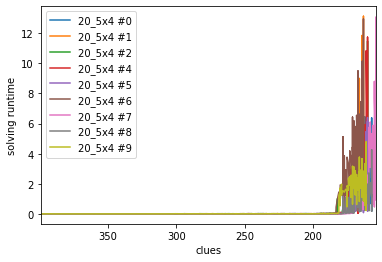

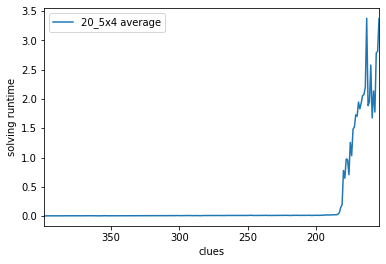






10_5x2





,remaining,runtime
count,3170,3170
mean,40.517666,0.009947
std,16.156417,0.006155
min,30.000000,0.000977
25%,33.000000,0.004999
50%,34.000000,0.009018
75%,37.000000,0.014000
max,99.000000,0.051003




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
5798,25,316,270,33,6,3,4.0,2,0.051003,10_5x2,4
4664,25,316,87,34,6,0,5.0,2,0.038010,10_5x2,1
5943,25,316,98,32,2,4,5.0,2,0.037025,10_5x2,5
5786,25,316,258,33,6,1,2.0,2,0.036028,10_5x2,4
5341,25,316,130,35,0,9,4.0,2,0.035002,10_5x2,3




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
4578,25,316,1,98,4,2,8.0,1,0.000977,10_5x2,1
6814,25,316,18,81,9,7,8.0,1,0.000992,10_5x2,8
5558,25,316,30,70,2,1,10.0,1,0.000992,10_5x2,4
5564,25,316,36,64,8,7,6.0,1,0.000996,10_5x2,4
4909,25,316,15,84,8,8,7.0,1,0.000998,10_5x2,2



Cell removal gave 1 unique solution:   663 or 20.91%
Cell removal gave 2+ solutions:        2507 or 79.09%


Distribution of Successfully removed values:


1.0     0.105581
4.0     0.104072
8.0     0.102564
10.0    0.101056
7.0     0.101056
9.0     0.099548
5.0     0.099548
3.0     0.098039
2.0     0.098039
6.0     0.090498
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


6.0     0.116075
3.0     0.112086
2.0     0.106502
5.0     0.104906
9.0     0.097726
1.0     0.096131
7.0     0.095333
10.0    0.092541
4.0     0.090945
8.0     0.087754
Name: orig_val, dtype: float64

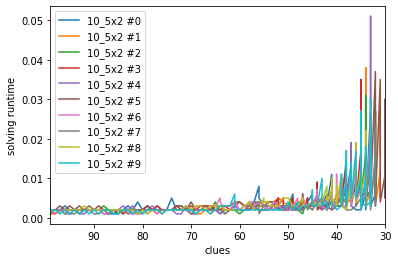

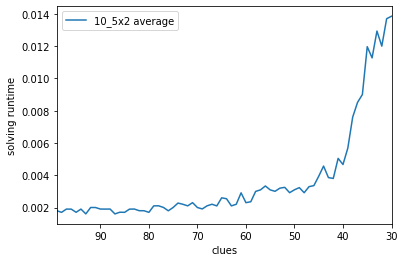






12_4x3





,remaining,runtime
count,4990,4990
mean,58.030862,0.021324
std,22.185389,0.016798
min,45.000000,0.000982
25%,48.000000,0.010000
50%,49.000000,0.020002
75%,52.000000,0.029001
max,143.000000,0.337025




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
11833,36,498,411,47,4,5,6.0,2,0.337025,12_4x3,8
11767,36,498,345,47,4,5,6.0,2,0.289019,12_4x3,8
11762,36,498,340,47,4,5,6.0,2,0.234016,12_4x3,8
11842,36,498,420,47,4,5,6.0,2,0.229017,12_4x3,8
9667,36,498,241,49,5,10,11.0,2,0.166010,12_4x3,4




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
7446,36,498,16,127,7,8,8.0,1,0.000982,12_4x3,0
7478,36,498,48,95,4,6,9.0,1,0.000986,12_4x3,0
7433,36,498,3,140,8,8,10.0,1,0.000988,12_4x3,0
7963,36,498,34,109,7,5,4.0,1,0.000988,12_4x3,1
11932,36,498,11,132,11,8,12.0,1,0.000990,12_4x3,9



Cell removal gave 1 unique solution:   949 or 19.02%
Cell removal gave 2+ solutions:        4041 or 80.98%


Distribution of Successfully removed values:


3.0     0.089568
9.0     0.087460
1.0     0.087460
11.0    0.086407
8.0     0.085353
12.0    0.085353
10.0    0.085353
2.0     0.080084
5.0     0.079031
7.0     0.079031
6.0     0.077977
4.0     0.076923
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


4.0     0.099728
5.0     0.097501
6.0     0.096263
7.0     0.093541
2.0     0.092551
10.0    0.086612
12.0    0.080673
11.0    0.073497
9.0     0.073002
1.0     0.071517
8.0     0.071269
3.0     0.063846
Name: orig_val, dtype: float64

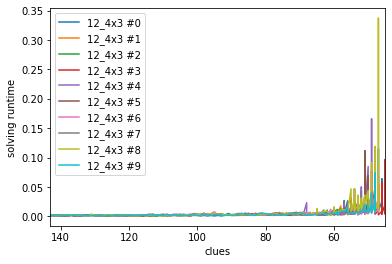

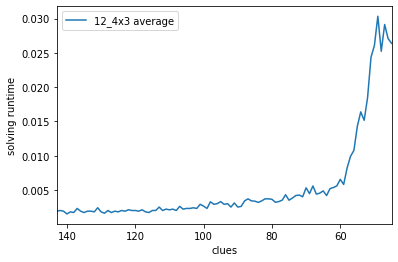






9_3x3





,remaining,runtime
count,2440,2440
mean,30.806557,0.008480
std,14.375688,0.005117
min,21.000000,0.000000
25%,23.000000,0.004000
50%,24.000000,0.008001
75%,28.250000,0.012001
max,80.000000,0.030003




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
1922,20,243,102,23,6,4,3.0,2,0.030003,9_3x3,0
3174,20,243,134,23,4,0,9.0,2,0.025013,9_3x3,5
3248,20,243,208,23,0,1,8.0,2,0.024008,9_3x3,5
2057,20,243,237,23,6,7,6.0,2,0.024002,9_3x3,0
3250,20,243,210,23,0,1,8.0,2,0.023014,9_3x3,5




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
3780,20,243,8,72,4,2,2.0,1,0.000000,9_3x3,8
3058,20,243,18,62,0,2,3.0,1,0.000988,9_3x3,5
3552,20,243,24,56,7,4,3.0,1,0.000996,9_3x3,7
1832,20,243,12,68,7,8,9.0,1,0.000996,9_3x3,0
2317,20,243,9,71,7,8,4.0,1,0.000998,9_3x3,2



Cell removal gave 1 unique solution:   566 or 23.20%
Cell removal gave 2+ solutions:        1874 or 76.80%


Distribution of Successfully removed values:


4.0    0.116608
1.0    0.114841
8.0    0.114841
3.0    0.113074
5.0    0.109541
9.0    0.109541
7.0    0.109541
2.0    0.107774
6.0    0.104240
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


6.0    0.127535
7.0    0.122199
5.0    0.117930
3.0    0.114728
9.0    0.110993
2.0    0.107791
4.0    0.105656
8.0    0.104055
1.0    0.089114
Name: orig_val, dtype: float64

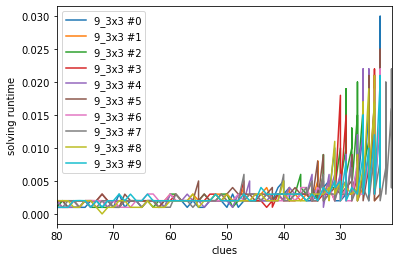

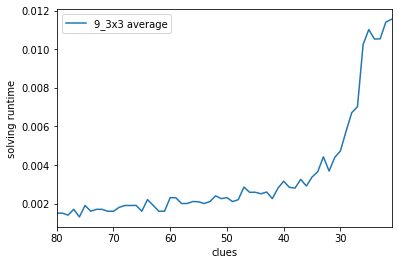






16_4x4





,remaining,runtime
count,10250,10250
mean,106.098829,0.251663
std,35.301792,0.285701
min,87.000000,0.001991
25%,91.000000,0.038022
50%,92.000000,0.116009
75%,97.000000,0.416023
max,255.000000,1.564114




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
21019,64,1024,534,87,11,1,1.0,2,1.564114,16_4x4,3
21273,64,1024,788,87,11,1,1.0,2,1.547113,16_4x4,3
26137,64,1024,527,91,4,6,14.0,2,1.497095,16_4x4,8
20970,64,1024,485,87,11,1,1.0,2,1.459105,16_4x4,3
20951,64,1024,466,87,15,9,6.0,2,1.458113,16_4x4,3




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
25611,64,1024,1,254,1,12,12.0,1,0.001991,16_4x4,8
17453,64,1024,43,212,15,3,11.0,1,0.001993,16_4x4,0
26647,64,1024,12,243,9,2,12.0,1,0.001995,16_4x4,9
17415,64,1024,5,250,9,12,5.0,1,0.001995,16_4x4,0
24612,64,1024,27,228,12,2,12.0,1,0.001995,16_4x4,7



Cell removal gave 1 unique solution:   1629 or 15.89%
Cell removal gave 2+ solutions:        8621 or 84.11%


Distribution of Successfully removed values:


3.0     0.065684
9.0     0.065684
16.0    0.065684
10.0    0.065071
6.0     0.063843
1.0     0.063229
5.0     0.063229
15.0    0.062615
14.0    0.062615
2.0     0.062001
7.0     0.062001
8.0     0.062001
4.0     0.060160
13.0    0.060160
11.0    0.058932
12.0    0.057090
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


12.0    0.074817
11.0    0.069945
4.0     0.069713
13.0    0.065538
1.0     0.064726
8.0     0.064494
2.0     0.063566
7.0     0.063218
15.0    0.062638
14.0    0.059158
6.0     0.058926
9.0     0.058462
16.0    0.057766
5.0     0.057302
10.0    0.054866
3.0     0.054866
Name: orig_val, dtype: float64

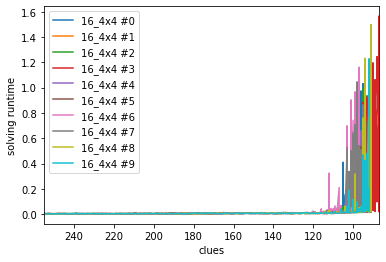

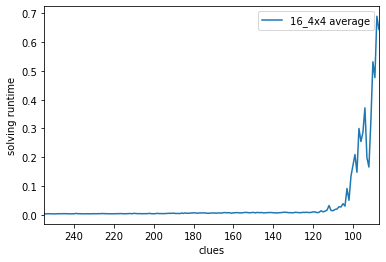






12_6x2





,remaining,runtime
count,4990,4990
mean,59.995792,0.017099
std,21.416247,0.011351
min,48.000000,0.000984
25%,50.000000,0.009003
50%,51.000000,0.016020
75%,55.000000,0.023012
max,143.000000,0.148014




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
14197,36,498,280,50,5,3,4.0,2,0.148014,12_6x2,3
14361,36,498,444,50,5,3,4.0,2,0.144007,12_6x2,3
14188,36,498,271,50,5,3,4.0,2,0.131010,12_6x2,3
14246,36,498,329,50,5,3,4.0,2,0.129023,12_6x2,3
14272,36,498,355,50,5,3,4.0,2,0.122007,12_6x2,3




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
13438,36,498,20,123,6,4,11.0,1,0.000984,12_6x2,2
12928,36,498,9,134,5,4,4.0,1,0.000988,12_6x2,1
15919,36,498,6,137,3,1,7.0,1,0.000992,12_6x2,7
16931,36,498,20,123,3,1,5.0,1,0.000998,12_6x2,9
13933,36,498,16,127,5,5,10.0,1,0.000998,12_6x2,3



Cell removal gave 1 unique solution:   927 or 18.58%
Cell removal gave 2+ solutions:        4063 or 81.42%


Distribution of Successfully removed values:


11.0    0.090615
8.0     0.088457
4.0     0.086300
3.0     0.084142
2.0     0.083064
6.0     0.083064
10.0    0.083064
1.0     0.081985
12.0    0.081985
7.0     0.080906
9.0     0.079827
5.0     0.076591
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


5.0     0.095742
6.0     0.091804
1.0     0.088358
9.0     0.088112
7.0     0.087620
4.0     0.083436
3.0     0.082451
2.0     0.082205
10.0    0.079498
8.0     0.077529
12.0    0.076544
11.0    0.066699
Name: orig_val, dtype: float64

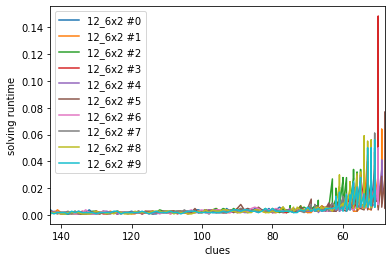

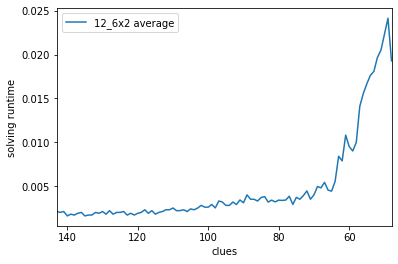






16_8x2





,remaining,runtime
count,10250,10250
mean,113.989854,0.149170
std,32.563813,0.196593
min,97.000000,0.001993
25%,100.000000,0.030005
50%,102.000000,0.063014
75%,105.000000,0.165032
max,255.000000,1.231071




slowest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
30367,64,1024,657,100,15,8,11.0,2,1.231071,16_8x2,2
31103,64,1024,368,99,3,14,3.0,2,1.231068,16_8x2,3
31350,64,1024,615,97,10,8,10.0,2,1.222073,16_8x2,3
31193,64,1024,458,99,3,14,3.0,2,1.206087,16_8x2,3
31636,64,1024,901,97,10,8,10.0,2,1.156061,16_8x2,3




fastest runtimes:


,clues,max_iter,iter,remaining,row,col,orig_val,sol_cnt,runtime,gsize,testnum
32804,64,1024,19,236,13,3,6.0,1,0.001993,16_8x2,5
29750,64,1024,40,215,6,15,13.0,1,0.001995,16_8x2,2
32794,64,1024,9,246,10,10,14.0,1,0.001995,16_8x2,5
32793,64,1024,8,247,2,7,6.0,1,0.001995,16_8x2,5
30736,64,1024,1,254,9,3,12.0,1,0.001997,16_8x2,3



Cell removal gave 1 unique solution:   1540 or 15.02%
Cell removal gave 2+ solutions:        8710 or 84.98%


Distribution of Successfully removed values:


7.0     0.068831
6.0     0.067532
3.0     0.065584
1.0     0.064286
12.0    0.063636
10.0    0.062987
16.0    0.062338
15.0    0.062338
8.0     0.061688
2.0     0.061688
11.0    0.061688
5.0     0.061039
14.0    0.061039
13.0    0.059091
9.0     0.059091
4.0     0.057143
Name: orig_val, dtype: float64



Distribution of Incorrectly removed values:


9.0     0.070379
13.0    0.069575
4.0     0.068886
5.0     0.065098
14.0    0.064638
2.0     0.064294
15.0    0.062801
10.0    0.062801
11.0    0.061998
1.0     0.061768
16.0    0.060620
8.0     0.060390
3.0     0.059816
12.0    0.059013
6.0     0.055224
7.0     0.052698
Name: orig_val, dtype: float64

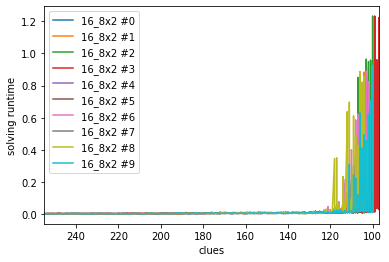

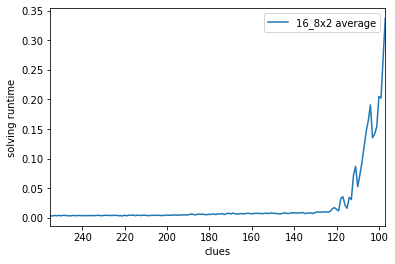

In [78]:
overall_stats = []
colors = cm.rainbow(np.linspace(0, 1, len(set(df['gsize'].tolist()))))
# fig, ax = plt.subplots()
for gsize in set(df['gsize'].tolist()):
    stats = print_indiv_stats(df, gsize)
    stats['gsize'] = gsize
    overall_stats.append(stats)
    
    gframe = df[df.gsize == gsize]
    
    remaining_count_runtime = gframe.groupby(['remaining'])['remaining', 'runtime'].agg({'remaining':'count',
                                                       'runtime':'mean'}).rename(columns={'remaining':'remaining_count',
                                                       'runtime':'runtime_mean'})
#     remaining_count_runtime.plot()

    
#     fig, ax = plt.subplots(figsize=(12,12))
    fig, ax = plt.subplots()
    for key, grp in gframe.groupby('testnum'):
        ax = grp.plot(ax=ax, kind='line', x='remaining', y='runtime', label=f"{gsize} #{key}")
        ax.invert_xaxis()
        ax.set_ylabel('solving runtime')
        ax.set_xlabel('clues')
#     plt.show()

    # df = df[['remaining', 'runtime']].groupby('remaining')
    # df.median().plot(kind='line')

#     fig2, ax2 = plt.subplots(figsize=(12,12))
    # ax2 = df[['remaining', 'runtime']].groupby('remaining').median().plot(kind='line')
    ax2 = gframe.groupby(['remaining'])[['runtime']].mean().plot(kind='line', y='runtime', label=f"{gsize} average")
    ax2.set_ylabel('solving runtime')
    ax2.set_xlabel('clues')
    ax2.invert_xaxis()
    plt.show()



In [ ]:
overall_stats

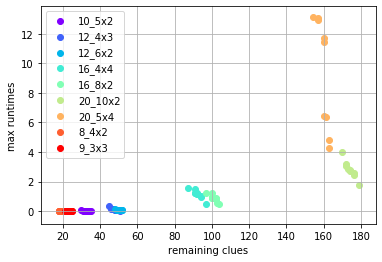

In [69]:
overall_stats = sorted(overall_stats, key=lambda k: k['gsize']) 
colors = cm.rainbow(np.linspace(0, 1, len(overall_stats)))
# overall_stats

for i, stats in enumerate(overall_stats):
    plt.scatter(x=stats['remaining'], y=stats['max_runtimes'], color=colors[i], label=stats['gsize'])

plt.xlabel('remaining clues')
plt.ylabel('max runtimes')
plt.legend()
plt.grid(True)